# 개요

## 코스닥

In [55]:
import pandas as pd
import yfinance as yf

start = '2024-11-12'
end = '2024-11-23'

tickers = pd.read_csv(f'/Users/leesangwon/Downloads/코스닥이상치.csv', encoding="utf-8")
# 티커 칼럼 리스트화
tickers_list = tickers['Original_Ticker'].tolist() if 'Original_Ticker' in tickers.columns else tickers.iloc[:, 0].tolist()
symbol = tickers_list

stock = yf.download(symbol, start, end)
stock_kosdaq = stock['Adj Close']

# 날짜 인덱스를 칼럼으로 변환
stock_kosdaq_reset = stock_kosdaq.reset_index()

stock_kosdaq_reset

# CSV 파일로 저장
stock_kosdaq_reset.to_csv('/Users/leesangwon/Downloads/코스닥실제주가_1112_1119.csv', index=False)

[*********************100%***********************]  49 of 49 completed


## 코스피

In [56]:
import pandas as pd
import yfinance as yf

start = '2024-11-12'
end = '2024-11-20'

tickers = pd.read_csv(f'/Users/leesangwon/Downloads/코스피이상치.csv', encoding="cp949")
# 티커 칼럼 리스트화
tickers_list = tickers['Original Ticker'].tolist() if 'Original Ticker' in tickers.columns else tickers.iloc[:, 0].tolist()
symbol = tickers_list

stock = yf.download(symbol, start, end)
stock_kospi= stock['Adj Close']

# 날짜 인덱스를 칼럼으로 변환
stock_kospi_reset = stock_kospi.reset_index()

stock_kospi

# CSV 파일로 저장
stock_kospi_reset.to_csv('/Users/leesangwon/Downloads/코스피실제주가_1112_1119.csv', index=False)


[*********************100%***********************]  17 of 17 completed


## 예측주가

In [71]:
df = pd.read_csv(f'/Users/leesangwon/Downloads/코스닥이상치.csv', encoding="utf-8")


In [72]:
# Original_Ticker 칼럼의 고유값을 리스트로 변환
original_tickers = df['Original_Ticker'].tolist()

# 결과 출력
original_tickers

['307930.KS',
 '053280.KS',
 '036000.KS',
 '226950.KS',
 '418470.KS',
 '291650.KS',
 '127120.KS',
 '099440.KS',
 '298380.KS',
 '255220.KS',
 '039560.KS',
 '115610.KS',
 '445680.KS',
 '424960.KS',
 '088800.KS',
 '220100.KS',
 '207760.KS',
 '067310.KS',
 '403870.KS',
 '226400.KS',
 '021080.KS',
 '115180.KS',
 '039020.KS',
 '050110.KS',
 '038460.KS',
 '019570.KS',
 '027830.KS',
 '317770.KS',
 '109670.KS',
 '043610.KS',
 '317530.KS',
 '256630.KS',
 '290090.KS',
 '028080.KS',
 '079940.KS',
 '314130.KS',
 '319400.KS',
 '053450.KS',
 '293780.KS',
 '090710.KS',
 '070300.KS',
 '039310.KS',
 '304840.KS',
 '205100.KS',
 '041440.KS',
 '399720.KS',
 '149950.KS',
 '057030.KS',
 '315640.KS']

In [73]:
# 필요한 라이브러리 로드
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# 티커 리스트
symbols = original_tickers


# 예측 결과를 담을 DataFrame
forecast_results = pd.DataFrame()

# 티커별로 예측 수행
for symbol in symbols:
    # 1. 데이터 다운로드 (수정 종가 사용)
    data = yf.download(symbol, start="2024-04-10", end="2024-10-11")
    data = data['Adj Close']
    
    if data.empty:
        print(f"데이터 다운로드 실패: {symbol}")
        continue
    else:
        print(f"{symbol} 데이터: {data.head()}")
    
    # 2. 데이터 전처리
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    # 3. 학습 데이터 생성
    sequence_length = 60
    X_train, y_train = [], []
    for i in range(sequence_length, len(scaled_data)):
        X_train.append(scaled_data[i-sequence_length:i, 0])
        y_train.append(scaled_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # 4. LSTM 모델 생성
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 5. 모델 학습
    model.fit(X_train, y_train, batch_size=32, epochs=20)

    # 6. 예측 준비
    test_data = scaled_data[-sequence_length:]
    test_data = np.array([test_data[:, 0]])
    test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))

    # 7. 29일 예측
    predictions = []
    for _ in range(29):
        next_pred = model.predict(test_data)[0][0]
        predictions.append(next_pred)
        test_data = np.append(test_data[:, 1:, :], [[[next_pred]]], axis=1)

    # 8. 예측 결과 복원
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # 9. 예측 결과 시각화
    forecast_index = pd.date_range(start=data.index[-1], periods=30, freq='B')[1:]
    
    # 예측 결과를 DataFrame에 저장
    forecast_df = pd.DataFrame({'Date': forecast_index, f'{symbol} Forecasted': predictions.flatten()})
    forecast_df.set_index('Date', inplace=True)

    # 결과를 종합 DataFrame에 추가
    if forecast_results.empty:
        forecast_results = forecast_df
    else:
        forecast_results = pd.merge(forecast_results, forecast_df, left_index=True, right_index=True, how='outer')

# 예측 결과 출력
forecast_results

[*********************100%***********************]  1 of 1 completed

307930.KS 데이터: Date
2024-04-11    6630.0
2024-04-12    6760.0
2024-04-15    6790.0
2024-04-16    6400.0
2024-04-17    6340.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1548
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0696
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0244
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0099
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0227
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0208
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0124
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0094
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0102
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0119
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0126
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0111
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0088
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0103
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0096
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

[*********************100%***********************]  1 of 1 completed

053280.KS 데이터: Date
2024-04-11    4570.0
2024-04-12    4595.0
2024-04-15    4505.0
2024-04-16    4525.0
2024-04-17    4530.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2948
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1881
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0945
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0614
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0743
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0756
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0603
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0507
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0573
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0651
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0633
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0597
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0532
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0553
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0464
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

[*********************100%***********************]  1 of 1 completed

036000.KS 데이터: Date
2024-04-11    1918.0
2024-04-12    1871.0
2024-04-15    1860.0
2024-04-16    1787.0
2024-04-17    1785.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0646
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0233
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0169
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0243
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0264
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0231
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0156
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0249
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0251
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0151
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0225
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0141
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0145
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0223
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0220
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

[*********************100%***********************]  1 of 1 completed

226950.KS 데이터: Date
2024-04-11    14410.0
2024-04-12    15130.0
2024-04-15    14670.0
2024-04-16    13960.0
2024-04-17    13940.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2537
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1142
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0365
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0362
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0573
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0349
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0227
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0235
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0283
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0291
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0306
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0246
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0221
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0203
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0226
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

[*********************100%***********************]  1 of 1 completed

418470.KS 데이터: Date
2024-04-11    18180.0
2024-04-12    17970.0
2024-04-15    17770.0
2024-04-16    17180.0
2024-04-17    17100.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0763
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0229
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0159
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0232
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0118
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0141
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0153
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0158
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0131
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0115
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0121
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0117
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0137
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0120
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

[*********************100%***********************]  1 of 1 completed

291650.KS 데이터: Date
2024-04-11    2880.0
2024-04-12    2600.0
2024-04-15    2670.0
2024-04-16    2625.0
2024-04-17    2675.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2806
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1142
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0445
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0737
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0619
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0550
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0472
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0447
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0477
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0476
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0481
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0373
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0390
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0385
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0402
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

[*********************100%***********************]  1 of 1 completed

127120.KS 데이터: Date
2024-04-11    2890.0
2024-04-12    2900.0
2024-04-15    2860.0
2024-04-16    2845.0
2024-04-17    2830.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3439 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1499
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0396
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0619
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0672
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0391
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0238
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0298
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0361
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0357
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0317
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0255
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0167
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0201
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0232
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

099440.KS 데이터: Date
2024-04-11    3680.0
2024-04-12    3725.0
2024-04-15    3610.0
2024-04-16    3475.0
2024-04-17    3530.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1595
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0880
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0327
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0156
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0288
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0234
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0165
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0146
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0170
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0176
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0175
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0158
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0139
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0143
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

[*********************100%***********************]  1 of 1 completed

298380.KS 데이터: Date
2024-04-11    22200.0
2024-04-12    23050.0
2024-04-15    22250.0
2024-04-16    22050.0
2024-04-17    21500.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3513 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1587
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0501
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0363
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0556
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0261
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0164
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0234
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0300
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0334
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0267
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0199
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0168
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0186
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0204
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

[*********************100%***********************]  1 of 1 completed

255220.KS 데이터: Date
2024-04-11    1540.0
2024-04-12    1501.0
2024-04-15    1489.0
2024-04-16    1499.0
2024-04-17    1520.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2709 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1209
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0575
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0681
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0601
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0391
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0299
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0326
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0353
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0335
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0290
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0230
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0237
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0213
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0221
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

039560.KS 데이터: Date
2024-04-11    3680.0
2024-04-12    3675.0
2024-04-15    3685.0
2024-04-16    3605.0
2024-04-17    3570.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2172 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0815
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0531
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0684
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0651
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0499
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0498
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0438
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0481
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0466
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0543
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0445
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0439
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0424
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0425
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

115610.KS 데이터: Date
2024-04-11    3495.0
2024-04-12    3520.0
2024-04-15    3420.0
2024-04-16    3285.0
2024-04-17    3320.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1003 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0474
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0291
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0351
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0320
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0219
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0222
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0222
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0226
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0243
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0209
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0196
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0194
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0189
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0209
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

[*********************100%***********************]  1 of 1 completed

445680.KS 데이터: Date
2024-04-11    46300.0
2024-04-12    47550.0
2024-04-15    45000.0
2024-04-16    43350.0
2024-04-17    44650.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0342 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0183
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0254
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0182
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0161
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0170
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0158
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0110
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0136
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0126
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0132
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0132
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0128
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0140
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

424960.KS 데이터: Date
2024-04-11    12770.0
2024-04-12    13020.0
2024-04-15    12620.0
2024-04-16    12840.0
2024-04-17    12220.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1155 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0564
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0302
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0369
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0348
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0269
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0232
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0233
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0230
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0220
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0206
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0181
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0200
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0183
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0191
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

[*********************100%***********************]  1 of 1 completed

088800.KS 데이터: Date
2024-04-11    2105.0
2024-04-12    2035.0
2024-04-15    2020.0
2024-04-16    2025.0
2024-04-17    2005.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0458 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0180
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0084
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0124
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0067
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0072
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0059
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0050
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0057
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

[*********************100%***********************]  1 of 1 completed

220100.KS 데이터: Date
2024-04-11    9510.0
2024-04-12    9400.0
2024-04-15    9270.0
2024-04-16    8800.0
2024-04-17    8710.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8546 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4909
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2576
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0791
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0229
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0760
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0625
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0237
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0135
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0202
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0311
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0308
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0252
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0164
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0137
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

207760.KS 데이터: Date
2024-04-11    2545.0
2024-04-12    2585.0
2024-04-15    2590.0
2024-04-16    2515.0
2024-04-17    2505.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0314 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0080
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0049
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0038
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0031
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

067310.KS 데이터: Date
2024-04-11    31500.0
2024-04-12    31000.0
2024-04-15    30700.0
2024-04-16    29400.0
2024-04-17    28900.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0520 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0158
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0086
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0078
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0082
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0041
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0031
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

403870.KS 데이터: Date
2024-04-11    42550.0
2024-04-12    42950.0
2024-04-15    43600.0
2024-04-16    41000.0
2024-04-17    42400.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1395 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0629
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0366
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0386
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0375
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0295
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0244
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0252
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0251
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0258
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0214
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0207
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0195
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0214
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

226400.KS 데이터: Date
2024-04-11    4280.0
2024-04-12    4415.0
2024-04-15    4385.0
2024-04-16    4490.0
2024-04-17    4360.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2730 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1434
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0427
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0420
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0597
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0347
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0277
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0309
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0371
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0344
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0274
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0234
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0255
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0240
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0225
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

[*********************100%***********************]  1 of 1 completed

021080.KS 데이터: Date
2024-04-11    2865.0
2024-04-12    2910.0
2024-04-15    2870.0
2024-04-16    2780.0
2024-04-17    2795.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1562 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0747
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0232
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0163
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0297
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0169
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0130
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0135
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0159
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0163
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0159
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0145
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0118
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0115
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0132
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

115180.KS 데이터: Date
2024-04-11    4370.0
2024-04-12    4560.0
2024-04-15    4540.0
2024-04-16    4410.0
2024-04-17    4400.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2203 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1013
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0322
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0442
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0454
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0276
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0271
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0354
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0261
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0259
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0205
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0220
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0241
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0237
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

039020.KS 데이터: Date
2024-04-11    2220.0
2024-04-12    2215.0
2024-04-15    2235.0
2024-04-16    2210.0
2024-04-17    2230.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3495 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1761
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0555
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0205
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0541
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0414
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0162
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0143
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0191
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0236
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0207
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0161
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0131
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0110
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0140
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

[*********************100%***********************]  1 of 1 completed

050110.KS 데이터: Date
2024-04-11    1427.0
2024-04-12    1415.0
2024-04-15    1400.0
2024-04-16    1378.0
2024-04-17    1391.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0876 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0269
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0259
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0258
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0187
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0154
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0193
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0195
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0196
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0162
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0151
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0150
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0149
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0156
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0167
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

038460.KS 데이터: Date
2024-04-11    5310.0
2024-04-12    5320.0
2024-04-15    5320.0
2024-04-16    5200.0
2024-04-17    5180.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0619 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0159
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0148
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0170
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0111
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0110
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0091
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0077
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0076
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

019570.KS 데이터: Date
2024-04-11    630.0
2024-04-12    632.0
2024-04-15    660.0
2024-04-16    735.0
2024-04-17    720.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1767
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0992
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0560
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0568
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0622
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0532
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0445
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0393
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0459
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0393
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0414
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0400
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0338
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0333
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0362
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

[*********************100%***********************]  1 of 1 completed

027830.KS 데이터: Date
2024-04-11    1951.0
2024-04-12    1938.0
2024-04-15    1985.0
2024-04-16    1965.0
2024-04-17    1959.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0343  
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0056
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0081
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0087
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0049
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0057
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

[*********************100%***********************]  1 of 1 completed

317770.KS 데이터: Date
2024-04-11    4120.0
2024-04-12    4260.0
2024-04-15    4050.0
2024-04-16    4170.0
2024-04-17    4275.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1330
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0512
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0285
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0432
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0212
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0124
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0168
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0202
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0179
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0129
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0110
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0091
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0100
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0100
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0095
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/

[*********************100%***********************]  1 of 1 completed

109670.KS 데이터: Date
2024-04-11    25300.0
2024-04-12    24400.0
2024-04-15    24050.0
2024-04-16    22200.0
2024-04-17    25400.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0024
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012    
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011    
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012    
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

043610.KS 데이터: Date
2024-04-11    3060.0
2024-04-12    3045.0
2024-04-15    3045.0
2024-04-16    2955.0
2024-04-17    2905.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1546
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0658
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0259
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0406
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0380
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0265
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0234
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0279
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0294
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0325
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0256
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0231
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0200
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0229
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0252
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/

[*********************100%***********************]  1 of 1 completed

317530.KS 데이터: Date
2024-04-11    4535.0
2024-04-12    4415.0
2024-04-15    4345.0
2024-04-16    4165.0
2024-04-17    4270.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0883 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0343
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0168
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0237
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0214
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0137
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0153
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0146
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0129
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0129
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0129
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0122
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0112
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms

[*********************100%***********************]  1 of 1 completed

256630.KS 데이터: Date
2024-04-11    1975.0
2024-04-12    1997.0
2024-04-15    1979.0
2024-04-16    1990.0
2024-04-17    1997.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0610
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0271
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0146
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0095
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0059
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0053
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/

[*********************100%***********************]  1 of 1 completed

290090.KS 데이터: Date
2024-04-11    10338.472656
2024-04-12    10319.861328
2024-04-15    10050.000000
2024-04-16     9910.416992
2024-04-17     9891.805664
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1174 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0527
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0170
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0224
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0251
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0152
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0111
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0121
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0149
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0129
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0119
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0113
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0120
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0114
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

028080.KS 데이터: Date
2024-04-11    3820.0
2024-04-12    3775.0
2024-04-15    3640.0
2024-04-16    3560.0
2024-04-17    3615.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1202 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0478
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0323
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0452
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0308
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0266
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0244
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0296
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0277
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0274
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0253
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0223
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0208
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0234
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0219
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms

[*********************100%***********************]  1 of 1 completed

079940.KS 데이터: Date
2024-04-11    18960.0
2024-04-12    19530.0
2024-04-15    18980.0
2024-04-16    18100.0
2024-04-17    17700.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0382
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0114
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0118
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0091
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0081
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0087
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0059
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0073
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0058
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/

[*********************100%***********************]  1 of 1 completed

314130.KS 데이터: Date
2024-04-11    7660.0
2024-04-12    7790.0
2024-04-15    7400.0
2024-04-16    7040.0
2024-04-17    6900.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0646
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0270
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0311
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0297
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0214
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0208
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0224
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0229
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0165
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0163
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0161
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0175
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0193
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0173
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0149
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

[*********************100%***********************]  1 of 1 completed

319400.KS 데이터: Date
2024-04-11    3005.0
2024-04-12    2905.0
2024-04-15    2880.0
2024-04-16    2795.0
2024-04-17    2830.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4131 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1802
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0437
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0994
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0625
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0249
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0379
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0487
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0538
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0462
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0359
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0279
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0347
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0372
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0375
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

[*********************100%***********************]  1 of 1 completed

053450.KS 데이터: Date
2024-04-11    6790.0
2024-04-12    6890.0
2024-04-15    7380.0
2024-04-16    7750.0
2024-04-17    8270.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0660
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0231
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0144
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0209
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0140
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0101
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0116
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0116
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0133
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0112
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0102
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0104
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0116
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0110
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

[*********************100%***********************]  1 of 1 completed

293780.KS 데이터: Date
2024-04-11    5960.0
2024-04-12    6010.0
2024-04-15    5980.0
2024-04-16    5820.0
2024-04-17    5830.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2444 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0915
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0418
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0596
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0530
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0264
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0229
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0270
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0352
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0263
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0217
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0187
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0186
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0201
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0188
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

[*********************100%***********************]  1 of 1 completed

090710.KS 데이터: Date
2024-04-11    2920.0
2024-04-12    2870.0
2024-04-15    2775.0
2024-04-16    2670.0
2024-04-17    2655.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1601 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0688
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0250
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0297
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0317
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0211
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0161
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0174
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0164
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0171
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0138
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0110
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0119
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0113
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

[*********************100%***********************]  1 of 1 completed

070300.KS 데이터: Date
2024-04-11    3025.0
2024-04-12    3000.0
2024-04-15    2890.0
2024-04-16    2795.0
2024-04-17    2845.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1852 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0807
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0555
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0693
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0610
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0419
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0392
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0427
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0373
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0360
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0317
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0255
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0253
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0266
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0227
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

039310.KS 데이터: Date
2024-04-11    2030.0
2024-04-12    2055.0
2024-04-15    2050.0
2024-04-16    1994.0
2024-04-17    1998.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1932 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0929
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0251
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0238
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0362
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0158
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0123
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0160
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0199
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0172
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0148
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0117
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0107
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0121
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0116
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

304840.KS 데이터: Date
2024-04-11    2880.0
2024-04-12    2855.0
2024-04-15    2810.0
2024-04-16    2710.0
2024-04-17    2700.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4020 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2643
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1397
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0529
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0238
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0599
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0370
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0237
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0192
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0255
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0253
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0278
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0220
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0198
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0189
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

205100.KS 데이터: Date
2024-04-11    2245.0
2024-04-12    2340.0
2024-04-15    2310.0
2024-04-16    2220.0
2024-04-17    2250.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0626 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0253
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0111
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0180
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0114
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0075
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0090
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0098
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0065
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0065
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0061
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

041440.KS 데이터: Date
2024-04-11    6430.0
2024-04-12    6520.0
2024-04-15    6530.0
2024-04-16    6320.0
2024-04-17    6430.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2526
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1174
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0648
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0669
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0712
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0488
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0430
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0518
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0455
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0388
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0482
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0435
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0351
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0382
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0359
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

[*********************100%***********************]  1 of 1 completed

399720.KS 데이터: Date
2024-04-11    104900.0
2024-04-12    110200.0
2024-04-15    101400.0
2024-04-16     96900.0
2024-04-17     96800.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0324 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0087
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0111
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0090
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0053
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0059
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0064
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0046
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0042
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0042
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

[*********************100%***********************]  1 of 1 completed

149950.KS 데이터: Date
2024-04-11    12290.0
2024-04-12    12800.0
2024-04-15    12510.0
2024-04-16    12100.0
2024-04-17    12190.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0845 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0344
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0127
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0221
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0193
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0109
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0124
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0127
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0120
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0098
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0093
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0093
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0092
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0105
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms

[*********************100%***********************]  1 of 1 completed

057030.KS 데이터: Date
2024-04-11    4030.0
2024-04-12    4120.0
2024-04-15    4105.0
2024-04-16    4100.0
2024-04-17    4085.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2093 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1137
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0349
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0353
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0534
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0387
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0353
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0270
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0324
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0362
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0384
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0307
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0237
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0244
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0257
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

[*********************100%***********************]  1 of 1 completed

315640.KS 데이터: Date
2024-04-11    7390.0
2024-04-12    7330.0
2024-04-15    7150.0
2024-04-16    7180.0
2024-04-17    7100.0
Name: Adj Close, dtype: float64
Epoch 1/20



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0990 
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0331
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0128
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0197
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0205
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0116
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0098
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0110
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0134
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0130
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0119
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0118
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0105
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0093
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0095
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms

,307930.KS Forecasted,053280.KS Forecasted,036000.KS Forecasted,226950.KS Forecasted,418470.KS Forecasted,291650.KS Forecasted,127120.KS Forecasted,099440.KS Forecasted,298380.KS Forecasted,255220.KS Forecasted,...,090710.KS Forecasted,070300.KS Forecasted,039310.KS Forecasted,304840.KS Forecasted,205100.KS Forecasted,041440.KS Forecasted,399720.KS Forecasted,149950.KS Forecasted,057030.KS Forecasted,315640.KS Forecasted
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-11,5140.425781,5195.014648,1692.894409,18035.947266,15243.872070,2311.161621,3038.150146,3115.373291,31206.197266,2361.607178,...,1257.878662,5659.582031,1575.535522,3545.797852,1781.246094,7708.178711,41987.246094,11790.892578,3554.066895,5515.477539
2024-10-14,5140.786621,5185.875488,1705.398438,18155.113281,15247.987305,2329.274902,3044.000488,3116.318359,31313.490234,2368.861816,...,1250.322632,5782.211914,1576.299072,3543.191650,1779.807251,7711.741699,41947.066406,11764.536133,3554.196777,5512.711426
2024-10-15,5140.766602,5179.432129,1713.788330,18202.968750,15256.041016,2342.543457,3049.901611,3116.452881,31362.408203,2378.814697,...,1240.922607,5946.937012,1576.445923,3542.307129,1778.300171,7720.374023,41884.054688,11739.068359,3553.251221,5508.215820
2024-10-16,5140.516602,5174.920898,1719.306152,18207.044922,15266.112305,2352.765625,3055.630859,3116.097412,31374.285156,2390.458252,...,1230.383301,6140.121582,1576.159912,3542.677979,1776.770508,7731.491699,41808.007812,11714.916016,3551.698242,5502.700195
2024-10-17,5140.133301,5171.769043,1722.820312,18184.826172,15277.039062,2361.031494,3061.089844,3115.459473,31363.033203,2403.100586,...,1219.195923,6351.801270,1575.582397,3543.928955,1775.246704,7743.534668,41725.097656,11692.333008,3549.822510,5496.653809
2024-10-18,5139.679688,5169.554199,1724.940308,18147.511719,15288.127930,2368.002930,3066.240234,3114.671631,31337.705078,2416.256104,...,1207.695801,6574.388184,1574.817505,3545.767822,1773.745728,7755.589844,41639.148438,11671.451172,3547.797363,5490.407227
2024-10-21,5139.193848,5167.972656,1726.093140,18102.193359,15298.985352,2374.083740,3071.074219,3113.818359,31304.167969,2429.578613,...,1196.107788,6802.102539,1573.939453,3547.974121,1772.277588,7767.152832,41552.527344,11652.317383,3545.726562,5484.172852
2024-10-22,5138.699707,5166.810547,1726.579468,18053.283203,15309.392578,2379.521240,3075.599854,3112.950928,31266.193359,2442.813477,...,1184.581177,7030.416992,1573.000000,3550.386719,1770.848511,7777.964844,41466.644531,11634.925781,3543.671875,5478.086426
2024-10-23,5138.212402,5165.921875,1726.610229,18003.462891,15319.242188,2384.469238,3079.830811,3112.102051,31226.183594,2455.770020,...,1173.210815,7255.671387,1572.033936,3552.891113,1769.461182,7787.920898,41382.332031,11619.231445,3541.670166,5472.228027


In [74]:
# 날짜 인덱스를 칼럼으로 변환
forecast_results_reset = forecast_results.reset_index()

forecast_results_reset

forecast_results_reset.to_csv('/Users/leesangwon/Downloads/코스닥예측주가_1011_1120.csv', index=False)


In [3]:
import matplotlib.pyplot as plt
import pandas as pd


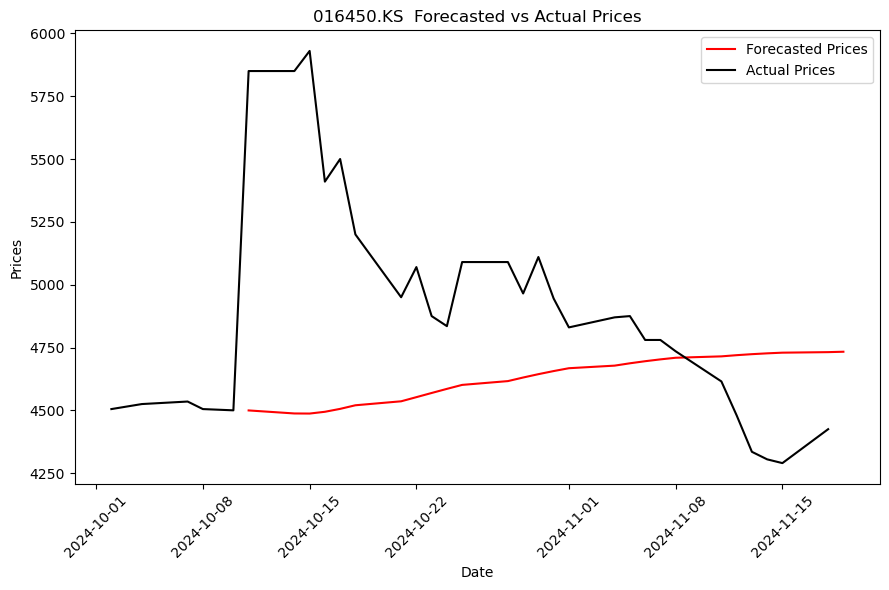

In [17]:
df = pd.read_csv(f'/Users/leesangwon/Downloads/한세_LSTM_forecast_actual_시각화용.csv', encoding="utf-8")
df["Date"] = pd.to_datetime(df["Date"], format="%Y.%m.%d")

# 라인차트 그리기
plt.figure(figsize=(9, 6))
plt.plot(df["Date"], df["Forecasted"], label="Forecasted Prices", color='r')
plt.plot(df["Date"], df["Actual Prices"], label="Actual Prices", color='black')
plt.title("016450.KS  Forecasted vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()